In [1]:
# Generates images for processing by the VLM

OUTPUT_SIZE = 224 # it's a square image
MAX_EMOJIS_PER_ROW = 3
MAX_EMOJI_SEQUENCE_LENGTH = MAX_EMOJIS_PER_ROW * MAX_EMOJIS_PER_ROW


count    1655.000000
mean        2.588520
std         1.281149
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        18.000000
Name: length, dtype: float64

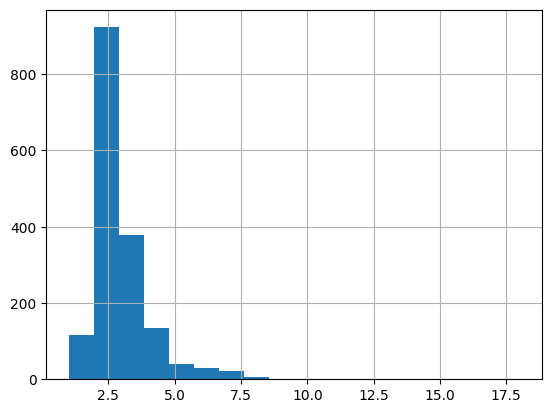

In [2]:
import pandas as pd
import grapheme

elco_df = pd.read_csv('elco.csv')

# count the lengths and graph it
elco_df['length'] = elco_df['EM'].apply(lambda x: len(list(grapheme.graphemes(x))))
elco_df['length'].hist(bins=elco_df['length'].max())
elco_df['length'].describe()

In [3]:
# count number of lengths > 9
elco_df[elco_df['length'] > 9].shape[0]
elco_df[elco_df['length'] > 4].shape[0]

103

In [57]:
import os
import cv2
import grapheme
import numpy as np
import pygame
import shutil

pygame.init()

def emoji_to_noto_filename(emoji, extension="png"):
    # Step 1: Get the Unicode code points of the emoji.
    codepoints = [f"U{ord(char):04X}" for char in emoji]
    # Step 2: Join the code points with underscores for ZWJ (Zero-Width Joiner) support.
    # Replace the "U" prefix with a lowercase "u" and remove the "+" symbol.
    file_name_parts = [f"u{codepoints[0][1:].lower()}"]  # First code point with "u"
    for codepoint in codepoints[1:]:
        str = codepoint[1:].lower()
        if str == 'fe0f': # Remove the variation selector
          continue
        file_name_parts.append(codepoint[1:].lower())  # Following code points without "u"
    
    # Step 3: Construct the filename (e.g., emoji_u1f9cf_200d_2640.png)
    file_name = "_".join(file_name_parts)
    return f"emoji_{file_name}.{extension}"

def get_png_image_for_emoji_google(emoji):
  IMAGE_DIR = 'noto-emoji-main/noto-emoji-main/png/72'
  filename = emoji_to_noto_filename(emoji)
  path = f'{IMAGE_DIR}/{filename}'
  if not os.path.exists(path):
    print(f"Couldn't find image for {emoji} at {path}")
    return None
  img = cv2.imread(path, cv2.IMREAD_COLOR)  # Use only RGB channels
  img_new_size = OUTPUT_SIZE // MAX_EMOJIS_PER_ROW
  img = cv2.resize(img, (img_new_size, img_new_size))
  return img


def generate_google_dataset():
  output_path = 'google_dataset'
  if os.path.exists(output_path):
    # delete the directory
    shutil.rmtree(output_path)

  os.makedirs(output_path, exist_ok=True)

  undone = 0

  i = -1
  for text in elco_df['EM']:
    i += 1
    units = list(grapheme.graphemes(text))
    units = [unit for unit in units if unit != ',' and unit != ' '] # don't ask me why they're there
    if len(units) > MAX_EMOJI_SEQUENCE_LENGTH:
      print(f"Skipping {text} because it's too long")
      undone += 1
      continue
    
    output_filename = f'{output_path}/{i}.png'
    
    x = 0
    y = 0
    # Make a white image of size OUTPUT_SIZE x OUTPUT_SIZE
    canvas = np.zeros((OUTPUT_SIZE, OUTPUT_SIZE, 3), dtype=np.uint8)  # RGB image
    
    img_new_size = OUTPUT_SIZE // MAX_EMOJIS_PER_ROW

    generated = True
    # Generate the image
    for j in range(len(units)):
      unit = units[j]
      try:
        img = get_png_image_for_emoji_google(unit)
      except Exception as e:
        undone += 1
        generated = False
        print(f"Error generating {unit}: {e}")
        break
      if img is None:
        undone += 1
        generated = False
        break

      # Ensure img is in RGB before placing it on the canvas
      if img.shape[2] == 4:  # If the image is RGBA, convert it to RGB
          img = img[..., :3]

      # Write the img to canvas starting at x, y
      x_pos = j % MAX_EMOJIS_PER_ROW
      y_pos = j // MAX_EMOJIS_PER_ROW
      x = x_pos * img_new_size
      y = y_pos * img_new_size
      canvas[y:y+img.shape[0], x:x+img.shape[1]] = img
    
    if generated:
      cv2.imwrite(output_filename, canvas)
  
  print(f"Undone: {undone}")

generate_google_dataset()


Skipping 👬👬👬👬👬👬👬👬👬👬👬 because it's too long
Couldn't find image for 🇷🇺 at noto-emoji-main/noto-emoji-main/png/72/emoji_u1f1f7_1f1fa.png
Couldn't find image for 🇦🇽 at noto-emoji-main/noto-emoji-main/png/72/emoji_u1f1e6_1f1fd.png
Couldn't find image for 🇺🇸 at noto-emoji-main/noto-emoji-main/png/72/emoji_u1f1fa_1f1f8.png
Couldn't find image for 🇦🇽 at noto-emoji-main/noto-emoji-main/png/72/emoji_u1f1e6_1f1fd.png
Skipping 📦📦📦📦📦📦📦📦📦✖️💯 because it's too long
Skipping 🧍‍♂️🧍‍♂️🧍‍♂️🧍‍♂️🧍‍♂️🧍‍♂️🧍‍♂️🧍‍♂️🧍‍♂️🕍 because it's too long
Skipping 🍏🍎🍐🍊🥔🍠🥐🥯🍞🫓🍑🥥🥝 because it's too long
Skipping 🍏🍌🥐🌮🥪🥨🧀🥚🥞🥬🌶️🍢🧋🌰🍪🎂🥂🍨 because it's too long
Skipping 💸🏦💵🪙💰💹🏧💲💳🤑 because it's too long
Couldn't find image for 🇸🇬 at noto-emoji-main/noto-emoji-main/png/72/emoji_u1f1f8_1f1ec.png
Couldn't find image for 🇻🇪 at noto-emoji-main/noto-emoji-main/png/72/emoji_u1f1fb_1f1ea.png
Couldn't find image for 🇫🇷 at noto-emoji-main/noto-emoji-main/png/72/emoji_u1f1eb_1f1f7.png
Couldn't find image for 🇺🇳 at noto-emoji-main/noto-emoji-main/